## Desafío 3 - DH - ML Clasificación

<a id="tabla_contenidos"></a> 
### Tabla de Contenidos

#### <a href='#section_proposito'>0. Propósito de esta Notebook</a>
- ##### <a href='#section_motivacion'>0.1 Motivación</a>
- ##### <a href='#section_dataset_info'>0.2 Detalles del Dataset</a>
- ##### <a href='#section_antecedentes'>0.3 Estado del Arte</a>

#### <a href='#section_preparacion'>1. Preparación del Dataset</a>
- ##### <a href='#section_importacion'>1.1 Importación</a>
- ##### <a href='#section_analisis'>1.2 Análisis Exploratorio</a>
- ##### <a href='#section_eliminacion'>1.3 Acotación de interés</a>
- ##### <a href='#section_split'>1.4 Selección de Features y target</a>

#### <a href='#section_algoritmos'>2. Algoritmos y predicción</a>
- ##### <a href='#knn'>2.1 K Nearest Neighbors (KNN)</a>
- ##### <a href='#reg_log'>2.2 Regresión Logística</a>
- ##### <a href='#naive'>2.3 Naive Bayes</a>
- ##### <a href='#naive_gaussian'>2.4 Naive Bayes Gaussian</a>

#### <a href='#section_consolidacion'>3. Consolidación</a>
- ##### <a href='#pipe'>3.1 Pipelines</a>
- ##### <a href='#conclusion'>3.2 Conclusión</a>

### <a id='section_proposito'>0. Propósito de esta Notebook</a>

#### <a id="section_motivacion">0.1 Motivación</a> 

<a id='section_preparacion'></a> 
### 1. Preparación del Dataset

### <a id="section_importacion">1.1 Importación de datos</a> 

#### Importación de datos de población y resultados de encuesta
Los datos de población nos permitirán realizar una exploración geográfica de la ubicación de los encuestados

In [173]:
# librerías
import numpy as np
import pandas as pd
import unicodedata

In [174]:
resultados_del_test = pd.read_csv("data/resultados-del-test.csv", delimiter = ",")

In [175]:
poblacion_por_barrio = pd.read_csv("data/caba_pob_barrios_2010.csv")

#### Unifico en un dataset
Elimino tildes en los nombres de los barrios de cada dataset y agrego población por barrio al resultado de las encuestas

In [176]:
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

In [177]:
poblacion_por_barrio.BARRIO = poblacion_por_barrio.BARRIO.apply(elimina_tildes).apply(lambda barrio: barrio.capitalize())

In [178]:
resultados_del_test.barrio = resultados_del_test.barrio.apply(elimina_tildes).apply(lambda barrio: barrio.capitalize())

In [179]:
poblacion_por_barrio.columns = ['barrio', 'poblacion']

In [180]:
poblacion_por_barrio = poblacion_por_barrio.set_index('barrio')

In [181]:
def obtener_poblacion_por_barrio(barrio):
    return poblacion_por_barrio.loc[barrio].poblacion

In [182]:
def imputar_barrio(barrio):
    barrios = poblacion_por_barrio.index.tolist()
    if barrio == "La boca": return "Boca"
    if barrio == "Montserrat": return "Monserrat"
    if barrio == "Villa general mitre": return "Villa gral. mitre"
    if barrio == "La paternal": return "Paternal"
    if barrio == "Otro": return np.random.choice(barrios)
    return barrio

In [183]:
resultados_del_test["barrio_completo"] = resultados_del_test.barrio.apply(imputar_barrio)

In [184]:
resultados_del_test["poblacion_por_barrio"] = resultados_del_test.barrio_completo.apply(obtener_poblacion_por_barrio)

#### Exporto y resguardo el dataset unificado

In [185]:
resultados_del_test.to_csv("data/dataset_joined.csv")

### <a id="section_analisis">1.2 Análisis Exploratorio</a> 


Importo el dataset unificado

In [186]:
df = pd.read_csv("data/dataset_joined.csv", delimiter = ",")
df.head(3)

,Unnamed: 0,fecha,hora,edad,genero,barrio,pregunta_1,pregunta_2,pregunta_3,pregunta_4,...,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,pregunta_11,pregunta_12,pregunta_13,barrio_completo,poblacion_por_barrio
0,0,2019-06-14,09:09:00,27,Mujer,Constitucion,A,A,A,B,...,B,C,C,B,C,B,C,C,Constitucion,44107
1,1,2019-06-13,23:20:00,17,Mujer,Otro,A,B,B,B,...,C,C,B,B,C,B,C,C,San telmo,20453
2,2,2019-06-13,16:33:00,15,Mujer,Recoleta,B,B,C,B,...,B,B,A,A,A,A,A,A,Recoleta,157932


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5676 entries, 0 to 5675
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            5676 non-null   int64 
 1   fecha                 5676 non-null   object
 2   hora                  5676 non-null   object
 3   edad                  5676 non-null   int64 
 4   genero                5676 non-null   object
 5   barrio                5676 non-null   object
 6   pregunta_1            5676 non-null   object
 7   pregunta_2            5676 non-null   object
 8   pregunta_3            5676 non-null   object
 9   pregunta_4            5676 non-null   object
 10  pregunta_5            5676 non-null   object
 11  pregunta_6            5676 non-null   object
 12  pregunta_7            5676 non-null   object
 13  pregunta_8            5676 non-null   object
 14  pregunta_9            5676 non-null   object
 15  pregunta_10           5676 non-null   

In [188]:
df_columnas = df[["fecha",'edad', 'genero', 'barrio','barrio_completo',
       'poblacion_por_barrio']]

#### Visualizamos los nulos

In [189]:
### librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [190]:
from IPython.display import Markdown, display

nulls_by_column = df_columnas.isnull().sum()
dataset_size = df.shape[0]

for column in nulls_by_column.index:
    column_nulls = nulls_by_column[column]
    null_percentage = 100 * column_nulls / dataset_size
    display(Markdown(f"* ```{column}``` tiene {column_nulls} nulos, lo cual representa el {null_percentage:.2f}%"))

* ```fecha``` tiene 0 nulos, lo cual representa el 0.00%

* ```edad``` tiene 0 nulos, lo cual representa el 0.00%

* ```genero``` tiene 0 nulos, lo cual representa el 0.00%

* ```barrio``` tiene 0 nulos, lo cual representa el 0.00%

* ```barrio_completo``` tiene 0 nulos, lo cual representa el 0.00%

* ```poblacion_por_barrio``` tiene 0 nulos, lo cual representa el 0.00%

#### Barrio de los encuestados

In [191]:
barrio = df.barrio.value_counts().head(5)

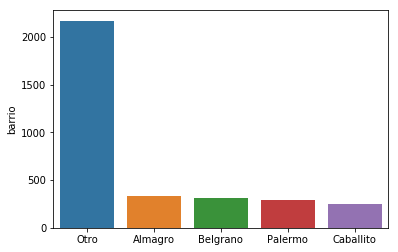

In [192]:
sns.barplot(x=barrio.index, y=barrio)

Vemos los primeros quince barrios con más encuestados

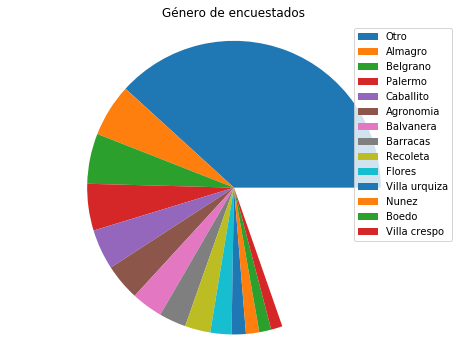

In [193]:
labels = df.barrio.value_counts(normalize=True).index[:14]
sizes = list(df.barrio.value_counts(normalize=True)[:14])

figura, axis = plt.subplots(figsize=(8,6))
axis.pie(sizes)
axis.axis('equal') 
axis.set_title('Género de encuestados')
axis.legend(labels)

#### Visualizamos las edades

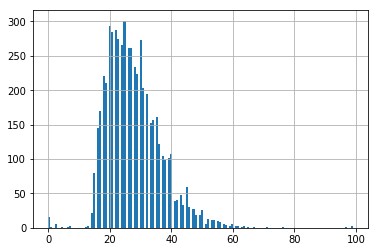

In [194]:
df.edad.hist(bins=150);

#####  Podemos escribir en el plot



In [195]:
#plt.hist(df.edad, bins=150);
#plt.annotate('¿Qué hacemos con esto?', xy=(15, 50), xytext=(2.5, 300),
            #arrowprops=dict(facecolor='black', shrink=15), fontsize=16)

#plt.annotate('y esto', xy=(12.5, 600), xytext=(16, 500),
            #arrowprops=dict(facecolor='black', shrink=15), fontsize=16
            #);
#plt.savefig('esto2')

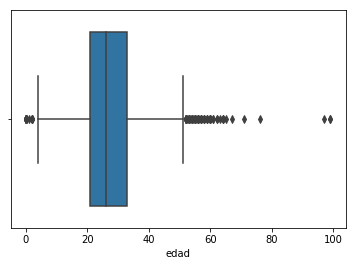

In [196]:
sns.boxplot(df.edad)

##### Quitamos los outliers

In [197]:
df_edad = df["edad"]

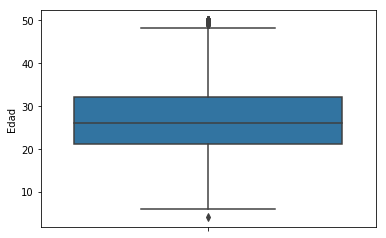

In [198]:
q1 = df_edad.quantile(0.25)
q2 = df_edad.quantile(0.5)
q3 = df_edad.quantile(0.75)

iqr = q3 - q1

up_threshold = q3 + 1.5 * iqr
low_threshold = q1 - 1.5* iqr

no_outliers_mask = (df_edad > low_threshold) & (df_edad < up_threshold)

ax = sns.boxplot(df_edad[no_outliers_mask], orient = 'v').set(
    xlabel='', 
    ylabel='Edad'
)

In [199]:
print(f"El skew es {df_edad[no_outliers_mask].skew()} cuando quitamos los outliers")

El skew es 0.5893768101027447 cuando quitamos los outliers


In [200]:
df_edad[no_outliers_mask].describe()

count    5561.000000
mean       27.400108
std         7.758342
min         4.000000
25%        21.000000
50%        26.000000
75%        32.000000
max        50.000000
Name: edad, dtype: float64

In [201]:
n_without_outliers = df_edad[no_outliers_mask].shape[0]
n_including_outliers = df_edad.shape[0]

taken_percentage = 100 * n_without_outliers / n_including_outliers
print(f"""
Sin outliers hemos tomado un {taken_percentage:.2f}% de los datos que teníamos, considerando solamente {n_including_outliers - n_without_outliers} registros como outliers
""")


Sin outliers hemos tomado un 97.97% de los datos que teníamos, considerando solamente 115 registros como outliers



#### Género de encuestados

In [202]:
df["genero"].value_counts()

Mujer     4736
Hombre     912
Otro        28
Name: genero, dtype: int64

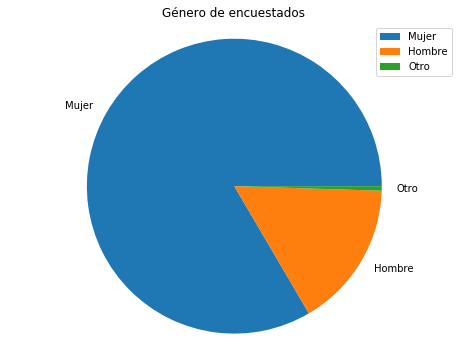

In [203]:
labels = df.genero.value_counts(normalize=True).index
sizes = list(df.genero.value_counts(normalize=True))

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(sizes, labels=labels)
ax1.axis('equal') 
ax1.set_title('Género de encuestados')
ax1.legend()

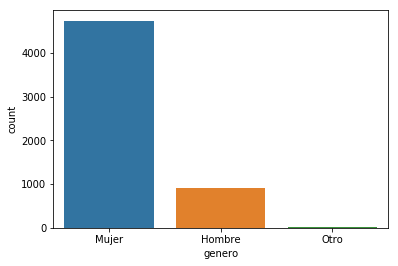

In [204]:
sns.countplot(x='genero', data=df)

#### Ploteamos cantidad de participantes de encuesta por barrio

In [205]:
porbarrio = df.barrio_completo.value_counts()
#porbarrio = barioss.rename_axis('BARRIO').reset_index(name='counts')
porbarrio.head(5)

Almagro      369
Belgrano     365
Palermo      341
Caballito    291
Agronomia    270
Name: barrio_completo, dtype: int64

In [206]:
porbarrio = porbarrio.to_frame().reset_index()

#### Respuestas según género

In [222]:
preguntas = ['1. ¿Cuando no están juntos/as, ¿tu pareja te controla preguntándote con quién estás,\n dónde y qué estás haciendo mensajeándote por celular?', 
 '2. ¿Revisa los mensajes de tu celular o te pidió la contraseña de tu correo electrónico,\n Facebook o Instagram como “prueba de confianza”?',
 '3. ¿Te acusa de haber sido infiel o coquetear con otras/os?',
 '4. ¿Sentís que están permanentemente en tensión y que, hagas lo que hagas, se irrita\n o te culpabiliza de sus cambios de humor?',
 '5. ¿Le molesta que hagas actividades de manera independiente, como estudiar, trabajar,\n visitar amigos/as, ir al gimnasio o elegir quedarte solo/a en tu casa?',
 '6. ¿Sentís que te alejaste o perdiste contacto con amigos/as o familiares desde que estás en pareja?',
 '7. ¿Te dice cómo tenés que vestirte o cómo debe ser tu apariencia?',
 '8. ¿Menosprecia en público o en privado tus opiniones?',
 '9. ¿Te dice que todo lo que hacés está mal o que no servís para nada?',
 '10. ¿Te amenaza con lastimarse/te si no lo/la obedecés o si querés terminar la relación?',
 '11. Después de un episodio violento, ¿se muestra cariñoso/a o atento/a\n y promete que nunca más lo hará y todo cambiará?',
 '12. ¿Indaga o cuestiona tus noviazgos anteriores?',
 '13. ¿Te sentís presionado/a a realizar determinadas prácticas sexuales por temor a que te deje?']

In [223]:
respuestas = ['A = Siempre', 'B = "A veces"', 'C = Nunca']

In [237]:
data = df[['genero'] + list(df.columns[6:18])]

In [238]:
for columna in data.drop('genero',axis=1).columns:
    data.loc[:,columna] = df.loc[:,columna].replace('A','Siempre').replace('B','A veces').replace('C','Nunca')

C:\Users\Foolface\.conda\envs\dh\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


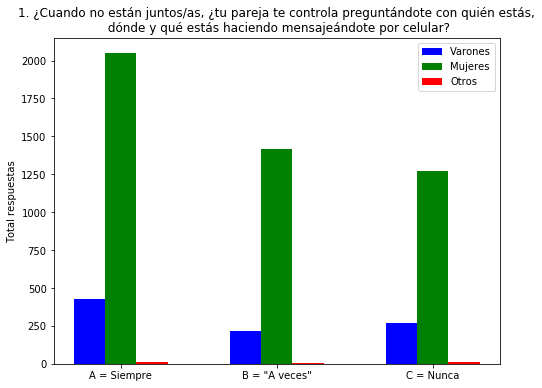

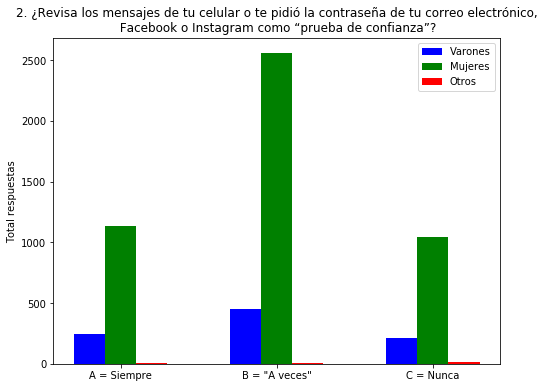

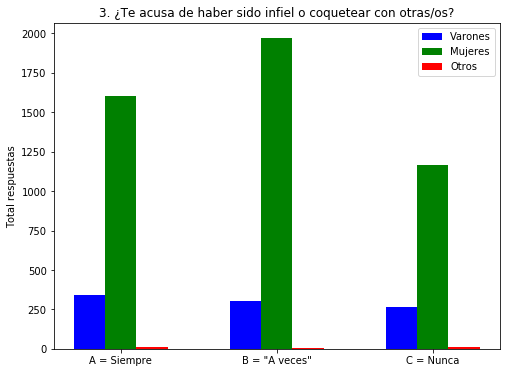

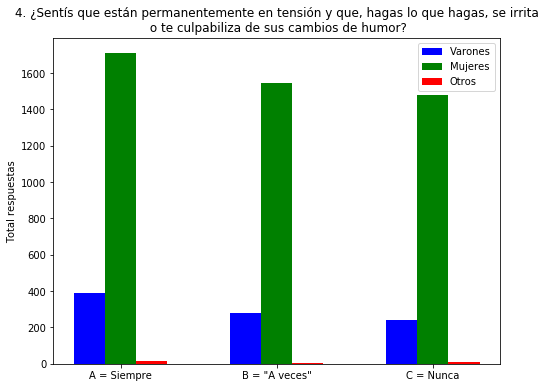

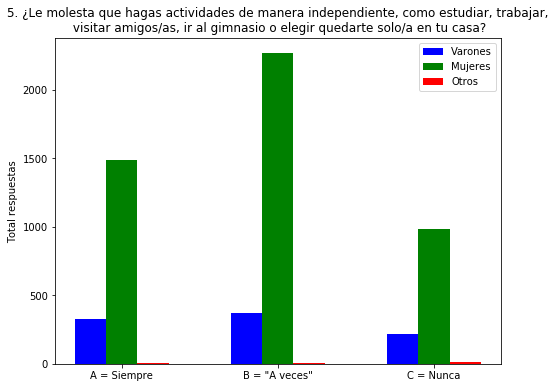

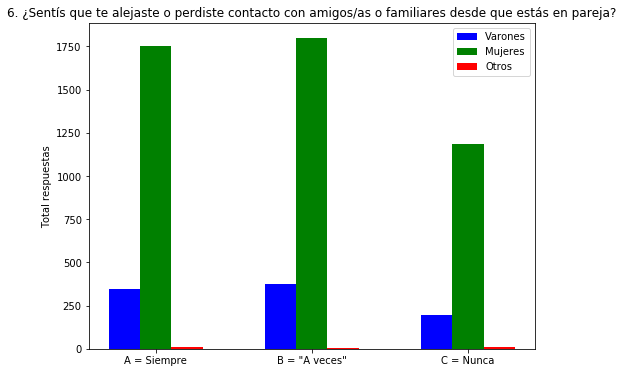

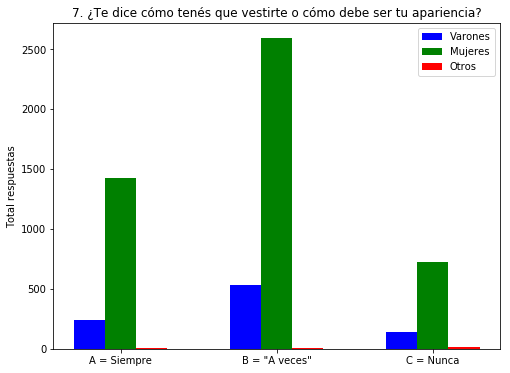

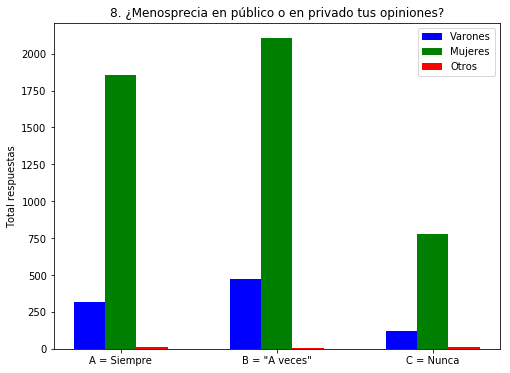

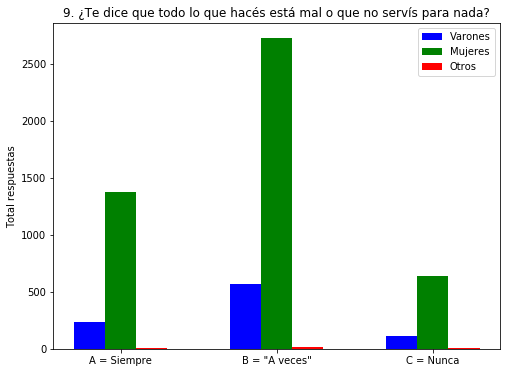

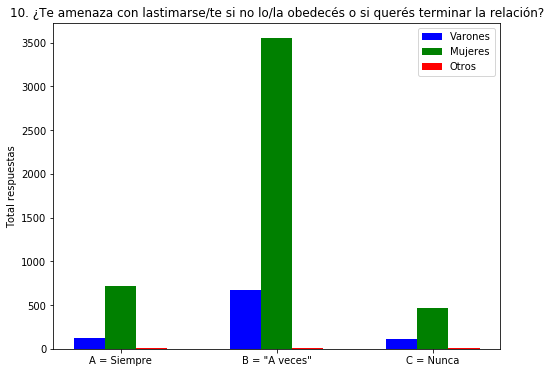

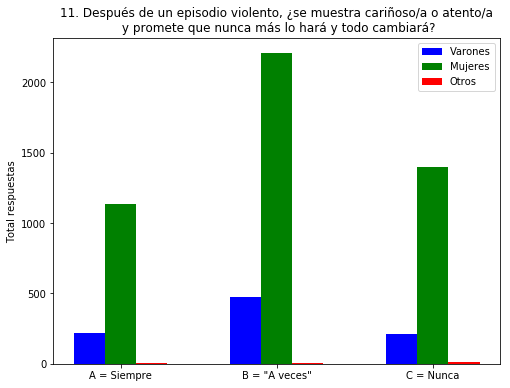

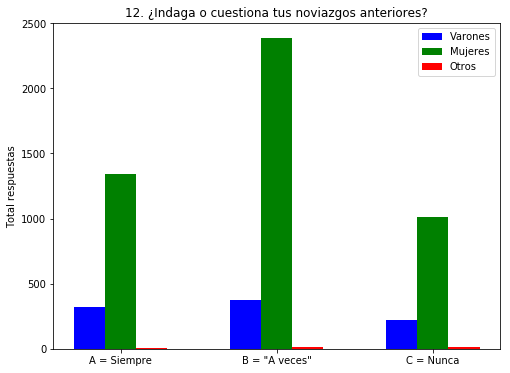

In [240]:
for num,columna in enumerate(data.drop('genero',axis=1).columns):
    # respuesta
    respuesta = set(np.array(list(data.groupby(columna).genero.value_counts().index))[:,0])
    # respuesta por hombres
    varones = list(data.groupby(columna).genero.value_counts())[1::3]
    # respusta por mujeres
    mujeres = list(data.groupby(columna).genero.value_counts())[::3]
    # respusta por otros
    otros = list(data.groupby(columna).genero.value_counts())[2::3]

    x = np.arange(len(respuesta))
    width = 0.2

    fig, ax = plt.subplots(figsize=(8,6))
    barra1 = ax.bar(x, varones, width, label='Varones', color='blue')
    barra2 = ax.bar(x+0.2, mujeres, width, label='Mujeres', color='green')
    barra3 = ax.bar(x+0.4, otros, width, label='Otros', color='red')

    ax.set_ylabel('Total respuestas')
    ax.set_title(preguntas[num])
    ax.set_xticks(x+0.2)
    ax.set_xticklabels(respuestas)
    ax.legend()